In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

In [755]:
events = pd.read_csv("events.csv", low_memory=False)

euro = events[events['competition_season'] == "UEFA Euro_2020"]
cdm = events[events['competition_season'] == "FIFA World Cup_2022"]
cdm_final = cdm[cdm['match_date'] == "2022-12-18"]





In [77]:
events22 = pd.read_csv("events_WC22.csv", low_memory=False)
df = events22

In [78]:
df = df[df["match_date"] == "2022-12-18"]

In [988]:
df = events.sort_index()

In [973]:
events.value_counts("type.name")

type.name
Pass                 657655
Ball Receipt*        614889
Carry                519401
Pressure             211395
Ball Recovery         71396
Duel                  44791
Clearance             29914
Block                 26015
Dribble               22656
Goal Keeper           20610
Miscontrol            19783
Interception          17345
Shot                  17179
Dispossessed          16909
Foul Committed        16520
Foul Won              15655
Dribbled Past         14054
Substitution           5065
Injury Stoppage        3671
Half End               2810
Half Start             2810
Tactical Shift         1700
Referee Ball-Drop      1552
50/50                  1502
Starting XI            1350
Shield                  964
Player Off              645
Player On               642
Error                   417
Bad Behaviour           352
Offside                 206
Own Goal For             78
Own Goal Against         78
Name: count, dtype: int64

In [79]:
df = df[df["type.name"].isin(["Pass","Carry", "Clearance", "Block", "Duel", "Dribble", "Shot", "Ball Recovery", "Goal Keeper"])]
df = df[df["period"] <= 4]

In [71]:
df["type.name"].value_counts()

type.name
Pass               1263
Ball Receipt*      1114
Carry               940
Pressure            361
Ball Recovery       115
Duel                 98
Dribble              54
Block                50
Foul Committed       48
Clearance            45
Foul Won             44
Goal Keeper          44
Shot                 38
Miscontrol           35
Dispossessed         34
Dribbled Past        31
Interception         28
Substitution         13
Half Start           10
Half End             10
Injury Stoppage       9
50/50                 8
Tactical Shift        7
Starting XI           2
Bad Behaviour         2
Offside               1
Shield                1
Player On             1
Player Off            1
Name: count, dtype: int64

## xT

In [854]:
obv_type= ['Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Foul Committed', 'Foul Won', 'Ball Recovery', 'Block',
       'Miscontrol', 'Clearance', 'Duel', 'Interception', 'Dribble',
       'Shot', 'Goal Keeper', 'Dispossessed', 'Dribbled Past','Offside']

In [855]:
df = df[df["type.name"].isin(obv_type)]

In [80]:
df["x"] = df["location"].apply(lambda x: x.split(",")[0][1:]).astype(float)
df["y"] = df["location"].apply(lambda x: x.split(",")[1][:-1]).astype(float)

In [81]:
prob_rows = np.array([
    [0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.7, 0.8, 1, 1.3, 1.8, 2.5, 3.7, 4.8, 6, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.7, 0.8, 1.1, 1.5, 2, 2.9, 4.2, 5.6, 7.5, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.6, 0.7, 0.9, 1.2, 1.6, 2.2, 3.4, 4.6, 6.8, 9.4, 10.3],
    [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.7, 0.9, 1.2, 1.6, 2.3, 3.4, 4.6, 6.8, 9.9, 12.3],
    [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.7, 1, 1.3, 1.7, 2.5, 3.4, 4.8, 6.8, 12.6, 15.8],
    [0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 0.9, 1.3, 1.7, 2.5, 3.3, 5.2, 8.9, 17.1, 41]
])

# Mirror the probabilities to create a full 12x16 grid
xT_values = np.vstack((prob_rows, np.flipud(prob_rows)))

# Normalize the probabilities to a scale of 0-1 (dividing by 100 since they were given as percentages)
xT_values /= 100

# Inverse the xT values in the axis x
xT_values_reverse = np.fliplr(xT_values)

# Function to map location to xT value
def map_location_to_xT(x,y, xT_values):
    # Map the x and y coordinates to the xT grid
    xT_x = min(int(np.floor(float(x) / 120 * 16)), 15)
    xT_y = min(int(np.floor(float(y) / 80 * 12)), 11)
    return xT_values[xT_y, xT_x]


# Apply the function to the DataFrame
df['xT'] = df.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values), axis=1)
df['rev_xT'] = df.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values_reverse), axis=1)

In [82]:
df.loc[(df["pass.outcome.name"].isnull())& (df["type.name"] == "Pass"), "pass.outcome.name"] = "Complete"
df.loc[(df["pass.outcome.id"].isnull()) & (df["type.name"] == "Pass"), "pass.outcome.id"] = 8.

In [83]:
def get_outcome(row):
    if row["type.name"] == "Pass":
        return row["pass.outcome.name"]
    elif row["type.name"] == "Dribble":
        return row["dribble.outcome.name"]
    elif row["type.name"] == "Shot":
        return row["shot.outcome.name"]
    else:
        return None
    
df["outcome"] = df.apply(get_outcome, axis=1)

In [96]:
df["end_location"].iloc[0]

'[48.0, 43.2]'

In [93]:
def get_end_location(row):
    if pd.notnull(row['pass.end_location']):
        return row['pass.end_location']

    elif pd.notnull(row['shot.end_location']):
        return row['shot.end_location']

    elif pd.notnull(row['carry.end_location']):
        return row['carry.end_location']

    elif row["type.name"] == "Dribble":
        # return end_location of next event
        row_index = row.name
        next_index = row_index + 1

        if next_index in df.index:  # Vérifie si le prochain index existe
            next_event = df.loc[next_index]
            return next_event.get("carry.end_location")
    else:
        return row['location']

def remove_brackets(x):
    if x[-1] == "]":
        return x[:-1]
    elif x[0] == "[":
        return x[1:]
    else:  
        return x

df['end_location'] = df.apply(get_end_location, axis=1)
df['end_x'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[0])) if pd.notnull(row['end_location']) else None, axis=1)
df['end_y'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[1])) if pd.notnull(row['end_location']) else None, axis=1)

df['end_z'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[-1])) if pd.notnull(row['end_location']) and row['type.name'] == 'Shot' else 0, axis=1)


df['xT.end'] = df.apply(lambda row: map_location_to_xT(row['end_x'], row['end_y'], xT_values) if pd.notnull(row['end_location']) else None, axis=1)

In [85]:
df.iloc[230:240][["type.name", "player.name", "outcome", "end_location", "carry.end_location", "end_x", "end_y", "end_z", "xT", "xT.end"]]

,type.name,player.name,outcome,end_location,carry.end_location,end_x,end_y,end_z,xT,xT.end
32738,Carry,Nicolás Hernán Otamendi,None,"[18.0, 14.7]","[18.0, 14.7]",18.0,14.7,0.0,0.004,0.004
32739,Pass,Nicolás Hernán Otamendi,Complete,"[6.0, 33.5]",NaN,6.0,33.5,0.0,0.004,0.004
32741,Carry,Damián Emiliano Martínez,None,"[6.5, 41.6]","[6.5, 41.6]",6.5,41.6,0.0,0.004,0.004
32742,Pass,Damián Emiliano Martínez,Complete,"[10.1, 48.9]",NaN,10.1,48.9,0.0,0.004,0.004
32744,Carry,Cristian Gabriel Romero,None,"[9.3, 48.9]","[9.3, 48.9]",9.3,48.9,0.0,0.004,0.004
32745,Pass,Cristian Gabriel Romero,Complete,"[27.9, 48.1]",NaN,27.9,48.1,0.0,0.004,0.004
32747,Carry,Enzo Fernandez,None,"[33.9, 51.1]","[33.9, 51.1]",33.9,51.1,0.0,0.004,0.005
32748,Pass,Enzo Fernandez,Incomplete,"[112.1, 58.1]",NaN,112.1,58.1,0.0,0.005,0.068
32751,Pass,Raphaël Varane,Complete,"[2.6, 29.0]",NaN,2.6,29.0,0.0,0.004,0.004
32754,Pass,Hugo Lloris,Incomplete,"[53.1, 19.2]",NaN,53.1,19.2,0.0,0.004,0.007


In [86]:
# cree une colonne xT.from qui est la valeur de xT de la ligne d'avant
df['xT.from'] = df['xT'].shift(1)


## Create the possesion 2

In [88]:
df["possession_2"] = df["possession"].copy()

for i in df["possession_2"].unique():
    sub = df[df["possession_2"] == i]

    if "Shot" in sub["type.name"].unique() and sub["type.name"].value_counts()["Shot"] > 1:
        shot_part = sub[sub["type.name"] == "Shot"].index

        for idx in shot_part[:-1]:
            df.loc[idx+2:, "possession_2"] += 1

## PSV

In [89]:
# Créer une colonne 'PSV' avec des valeurs par défaut de 0
df['PSVF'] = .0

for match in df['match_id'].unique():
    # Identifier les indices des tirs dans le dataframe
    shoot_indices = df[(df['type.name'] == 'Shot') & (df["match_id"] == match)].index

    # Calculer le PSV pour chaque séquence de possession
    for idx in shoot_indices:
        possession_idx = df.loc[idx, 'possession_2']
        possession_events = df[df['possession_2'] == possession_idx]

        # Calculer le PSV pour la séquence de possession
        total_xG = df.loc[idx]['shot.statsbomb_xg'].astype(float)
        df.loc[(df['possession_2'] == possession_idx) & (df["match_id"] == match ), 'PSVF'] = total_xG

In [90]:
# Créer une colonne 'PSV' avec des valeurs par défaut de 0
df['PSVA'] = .0

for match in df['match_id'].unique():
    # Identifier les indices des tirs dans le dataframe
    shoot_indices = df[(df['type.name'] == 'Shot') & (df["match_id"] == match)].index
    prev_psv = 0
    
    for i, p in enumerate(df[df["match_id"] == match]["possession"].unique()):
        tmp_psvf = df.loc[(df['possession'] == p) & (df["match_id"] == match), 'PSVF']
        tmp_team = df.loc[(df['possession'] == p) & (df["match_id"] == match), 'possession_team.name']
        prev_team = tmp_team.iloc[0]
        prev_psv = tmp_psvf.iloc[0]
        if len(df.loc[(df["possession"] == p - 1) & (df["match_id"] == match), "PSVF"]) == 0:
            df.loc[(df["possession"] == p - 1) & (df["match_id"] == match), "PSVA"] = 0

        elif (df.loc[(df["possession"] == p - 1) & (df["match_id"] == match), "possession_team.name"].iloc[0]) == prev_team :
            df.loc[(df["possession"] == p - 1) & (df["match_id"] == match), "PSVA"] = 0
        else :
            df.loc[(df["possession"] == p - 1) & (df["match_id"] == match), "PSVA"] = prev_psv
            
        
        

In [91]:
# pour les blocks, clearances, ball recovery, et goal keeper, on va attribuer le PSV de la possession précédente
df.loc[(df['type.name'] == 'Block') | (df['type.name'] == 'Clearance') | (df['type.name'] == 'Ball Recovery') | (df['type.name'] == 'Goal Keeper'), 'PSVA'] = df.loc[(df['type.name'] == 'Block') | (df['type.name'] == 'Clearance') | (df['type.name'] == 'Ball Recovery') | (df['type.name'] == 'Goal Keeper'), 'PSVF']

In [92]:
df[(df["type.name"] == "Duel")& (df["player.name"] == "Dayotchanculle Upamecano")][[ "minute", "type.name", "player.name", "PSVF", "PSVA", "xT", "xT.end", "rev_xT", "xT.from"]]

,minute,type.name,player.name,PSVF,PSVA,xT,xT.end,rev_xT,xT.from
32832,13,Duel,Dayotchanculle Upamecano,0.000000,0.0,0.010,0.010,0.010,0.007
33337,32,Duel,Dayotchanculle Upamecano,0.000000,0.0,0.005,0.005,0.052,0.042
33625,38,Duel,Dayotchanculle Upamecano,0.000000,0.0,0.005,0.005,0.013,0.005
36147,99,Duel,Dayotchanculle Upamecano,0.023032,0.0,0.089,0.089,0.005,0.048
36544,115,Duel,Dayotchanculle Upamecano,0.030757,0.0,0.089,0.089,0.005,0.060


In [60]:
df[["minute","possession", "possession_2","possession_team.name", "team.name","player.name", "type.name","xT","xT.from","rev_xT","xT.end", "PSVF", "PSVA", "shot.statsbomb_xg"]].loc[36361:36421]

,minute,possession,possession_2,possession_team.name,team.name,player.name,type.name,xT,xT.from,rev_xT,xT.end,PSVF,PSVA,shot.statsbomb_xg
36361,105,223,224,Argentina,Argentina,Leandro Daniel Paredes,Pass,0.023,0.023,0.005,0.034,0.000000,0.000000,NaN
36363,105,223,224,Argentina,Argentina,Lionel Andrés Messi Cuccittini,Carry,0.034,0.023,0.004,0.034,0.000000,0.000000,NaN
36364,105,223,224,Argentina,Argentina,Lionel Andrés Messi Cuccittini,Pass,0.034,0.034,0.004,0.068,0.000000,0.000000,NaN
36366,105,223,224,Argentina,Argentina,Gonzalo Ariel Montiel,Pass,0.068,0.034,0.004,0.126,0.000000,0.000000,NaN
36367,106,224,225,France,France,Hugo Lloris,Pass,0.004,0.068,0.410,0.023,0.000000,0.000000,NaN
36368,106,225,226,Argentina,Argentina,Cristian Gabriel Romero,Pass,0.004,0.004,0.034,0.004,0.000000,0.000000,NaN
36370,106,225,226,Argentina,Argentina,Gonzalo Ariel Montiel,Carry,0.004,0.004,0.020,0.004,0.000000,0.000000,NaN
36371,106,225,226,Argentina,Argentina,Gonzalo Ariel Montiel,Pass,0.004,0.004,0.018,0.004,0.000000,0.000000,NaN
36373,106,225,226,Argentina,Argentina,Leandro Daniel Paredes,Carry,0.004,0.004,0.022,0.005,0.000000,0.000000,NaN
36374,106,225,226,Argentina,Argentina,Leandro Daniel Paredes,Pass,0.005,0.004,0.023,0.006,0.000000,0.000000,NaN


In [107]:
df.loc[36416:36419][["minute","possession", "possession_2","possession_team.name", "team.name","player.name", "goalkeeper.outcome.name","type.name","xT","xT.from","rev_xT","xT.end", "PSVF", "PSVA", "shot.statsbomb_xg"]]

,minute,possession,possession_2,possession_team.name,team.name,player.name,goalkeeper.outcome.name,type.name,xT,xT.from,rev_xT,xT.end,PSVF,PSVA,shot.statsbomb_xg
36416,107,228,229,Argentina,Argentina,Lautaro Javier Martínez,NaN,Shot,0.126,0.068,0.004,0.171,0.104072,0.000000,0.104072
36417,107,228,229,Argentina,France,Hugo Lloris,In Play Danger,Goal Keeper,0.004,0.126,0.410,0.004,0.104072,0.104072,NaN
36418,107,228,230,Argentina,Argentina,Lionel Andrés Messi Cuccittini,NaN,Ball Recovery,0.171,0.004,0.005,0.171,0.488404,0.488404,NaN
36419,107,228,230,Argentina,Argentina,Lionel Andrés Messi Cuccittini,NaN,Shot,0.171,0.171,0.005,0.171,0.488404,0.000000,0.488404


## Model

In [839]:
list(df.columns)

['match_id', 'competition_season', 'match_date', 'match_outcome', 'id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'duration', 'type.id', 'type.name', 'possession_team.id', 'possession_team.name', 'play_pattern.id', 'play_pattern.name', 'team.id', 'team.name', 'tactics.formation', 'tactics.lineup', 'related_events', 'location', 'player.id', 'player.name', 'position.id', 'position.name', 'pass.recipient.id', 'pass.recipient.name', 'pass.length', 'pass.angle', 'pass.height.id', 'pass.height.name', 'pass.end_location', 'pass.body_part.id', 'pass.body_part.name', 'pass.type.id', 'pass.type.name', 'carry.end_location', 'pass.cross', 'pass.outcome.id', 'pass.outcome.name', 'ball_receipt.outcome.id', 'ball_receipt.outcome.name', 'under_pressure', 'clearance.right_foot', 'clearance.body_part.id', 'clearance.body_part.name', 'shot.statsbomb_xg', 'shot.end_location', 'shot.technique.id', 'shot.technique.name', 'shot.body_part.id', 'shot.body_part.name', 'shot.type.id', 'sh

In [948]:
df.fillna(0, inplace=True)


In [949]:
## create a feature distance to goal
df['distance_to_goal'] = ((df['x'] - 120)**2 + (df['y'] - 40)**2)**0.5

## angle to goal (posts)
a2 = ((df['x'] - 120)**2 + (df['y'] - 40-3.66)**2)
c2 = ((df['x'] - 120)**2 + (df['y'] - 40 + 3.66)**2)
df['angle_to_goal'] = np.degrees(np.arccos((a2 + c2 - (7.3)**2)/(2*(a2**0.5)*(c2**0.5))))


/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_50390/2158508925.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['distance_to_goal'] = ((df['x'] - 120)**2 + (df['y'] - 40)**2)**0.5
/Users/thomassinapi/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_50390/2158508925.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['angle_to_

In [950]:
# Select the columns to drop
column_name = df.columns[df.columns.str.endswith("name")]
end_location = df.columns[df.columns.str.endswith("end_location")]
to_drop = [*column_name, *end_location] + ["id", "index", "match_id", "match_date", "period", "player.id", "player.name",
                                           "substitution.replacement.id", "substitution.replacement.name",
                                           "match_outcome", "minute", "second", "possession", "possession_2",
                                           "competition_season", "timestamp", "half_start.late_video_start", "injury_stoppage.in_chain", "bad_behaviour.card.id",
                                           "tactics.lineup", "tactics.formation",
                                            "player.id", "pass.recipient.id",
                                           "related_events", "location", "PSV", "shot.aerial_won",
                                           "shot.statsbomb_xg",
                                            "pass.shot_assist", "pass.goal_assist", "pass.assisted_shot_id"
                                           ]


# Select the features and the target
X = df.drop(to_drop, axis=1)
y = df["PSV"]

# Transform the categorical variables into numerical variables
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.Categorical(X[col]).codes

In [845]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict the PSV
y_pred = rf.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.093193602877279


In [847]:
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.049866497032265866


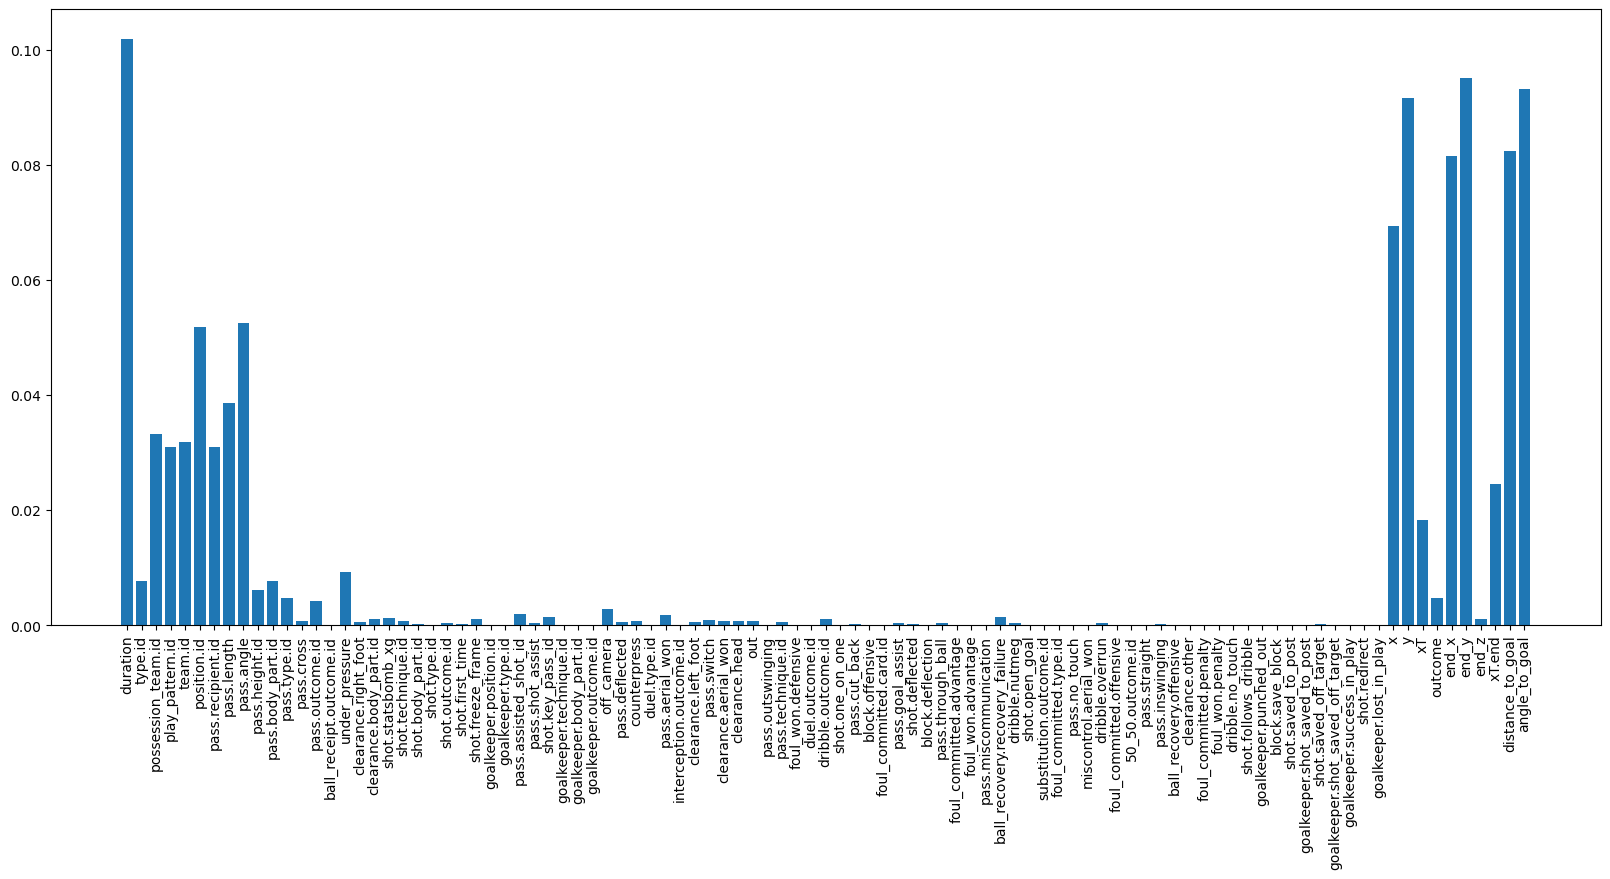

In [846]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, rf.feature_importances_)

plt.xticks(rotation=90)
plt.show()

In [951]:
from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict the PSV
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.0039063197839969
R2 Score: 0.14825958176809428


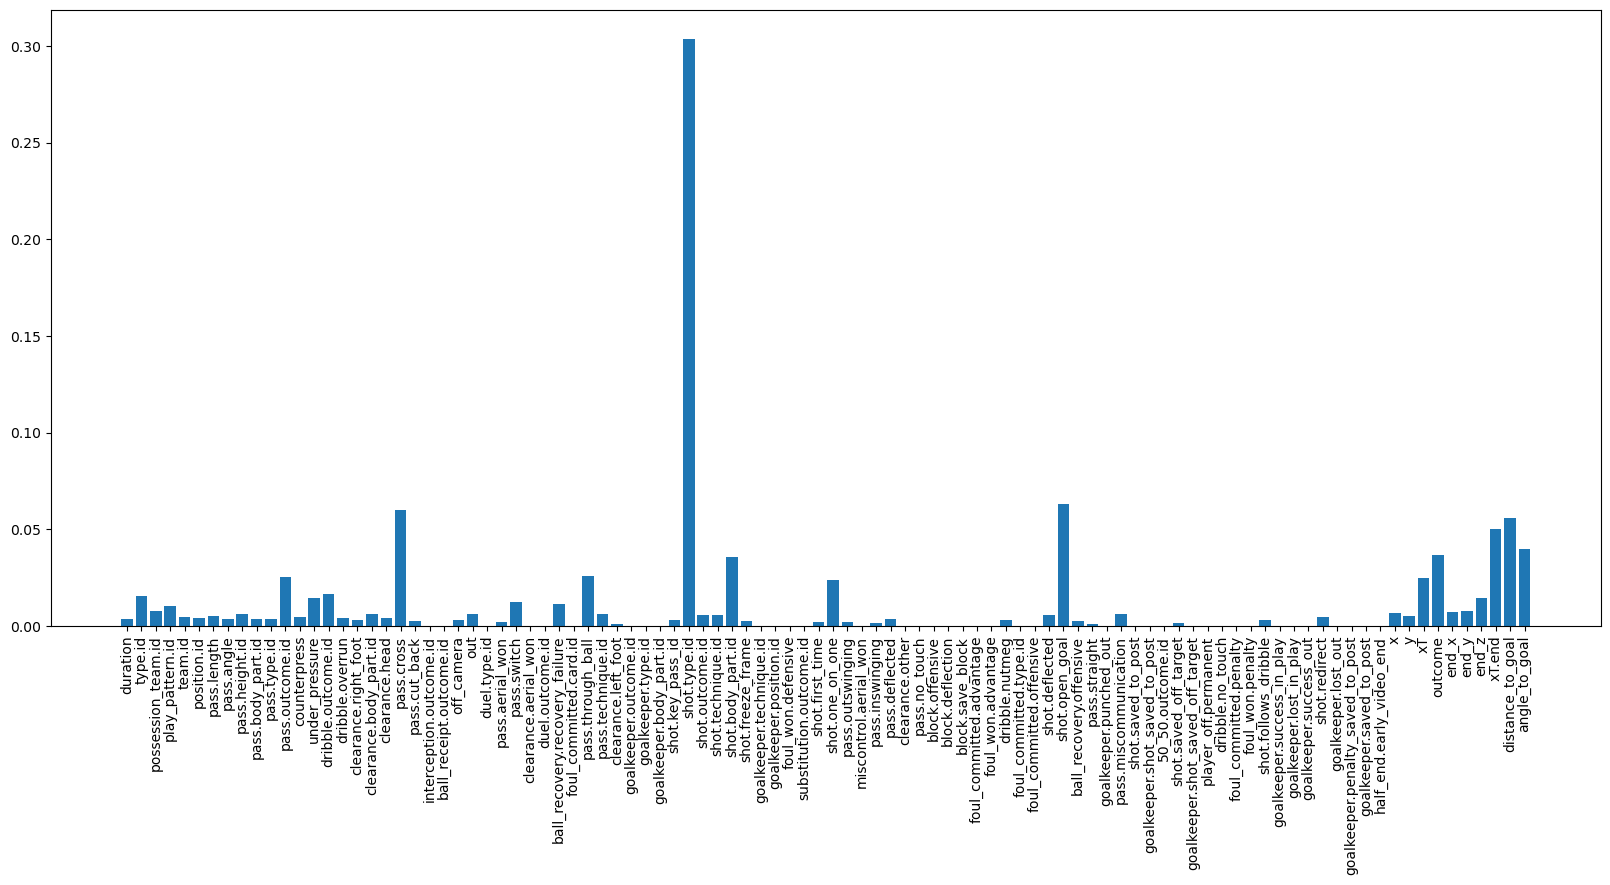

In [952]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [530]:
df["type.name"].value_counts()  

type.name
Pass             68515
Carry            53764
Ball Recovery     5821
Clearance         2684
Dribble           1793
Shot              1453
Dispossessed      1431
Name: count, dtype: int64

In [561]:
r2_score(y_test, y_pred)

0.16298867089905933

In [562]:
X_test["pred"] = y_pred

In [563]:
X_test["true"] = y_test

In [564]:
X_test[["type.id", "xT", "xT.end", "shot.statsbomb_xg", "pred", "true"]].head(110)

,type.id,xT,xT.end,shot.statsbomb_xg,pred,true
882093,43,0.042,0.068,0.000000,0.022996,0.074439
400488,43,0.006,0.006,0.000000,0.012850,0.000000
1690489,43,0.004,0.004,0.000000,0.012367,0.000000
325005,30,0.004,0.004,0.000000,0.008768,0.069583
591485,30,0.004,0.005,0.000000,0.019431,0.000000
729701,43,0.003,0.003,0.000000,-0.002593,0.000000
1076935,43,0.017,0.025,0.000000,0.019441,0.139977
1828057,30,0.012,0.034,0.000000,0.032153,0.000000
1055857,16,0.068,0.171,0.033629,0.043706,0.033629
1321424,43,0.013,0.012,0.000000,0.022108,0.000000


In [986]:
passes = df[df["type.name"] == "Shot"]

column_name = passes.columns[passes.columns.str.endswith("name")]
end_location = passes.columns[passes.columns.str.endswith("end_location")]
to_drop = [*column_name, *end_location] + ["id", "index", "match_id", "match_date", "period", "player.id", "player.name",
                                           "substitution.replacement.id", "substitution.replacement.name",
                                           "match_outcome", "minute", "second", "possession", "possession_2",
                                           "competition_season", "timestamp", "half_start.late_video_start", "injury_stoppage.in_chain", "bad_behaviour.card.id",
                                           "tactics.lineup", "tactics.formation", "pass.recipient.id",
                                           "related_events", "location", "PSV", "shot.aerial_won",
                                            "shot.statsbomb_xg",
                                            "pass.shot_assist", "pass.goal_assist", "pass.assisted_shot_id"
                                           ]


# Select the features and the target
X = passes.drop(to_drop, axis=1)
y = passes["PSV"]

# Transform the categorical variables into numerical variables
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.Categorical(X[col]).codes

In [983]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [984]:
# Create the model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Mean Squared Error: 0.004860500280127132
R2 Score: 0.7902152289287391


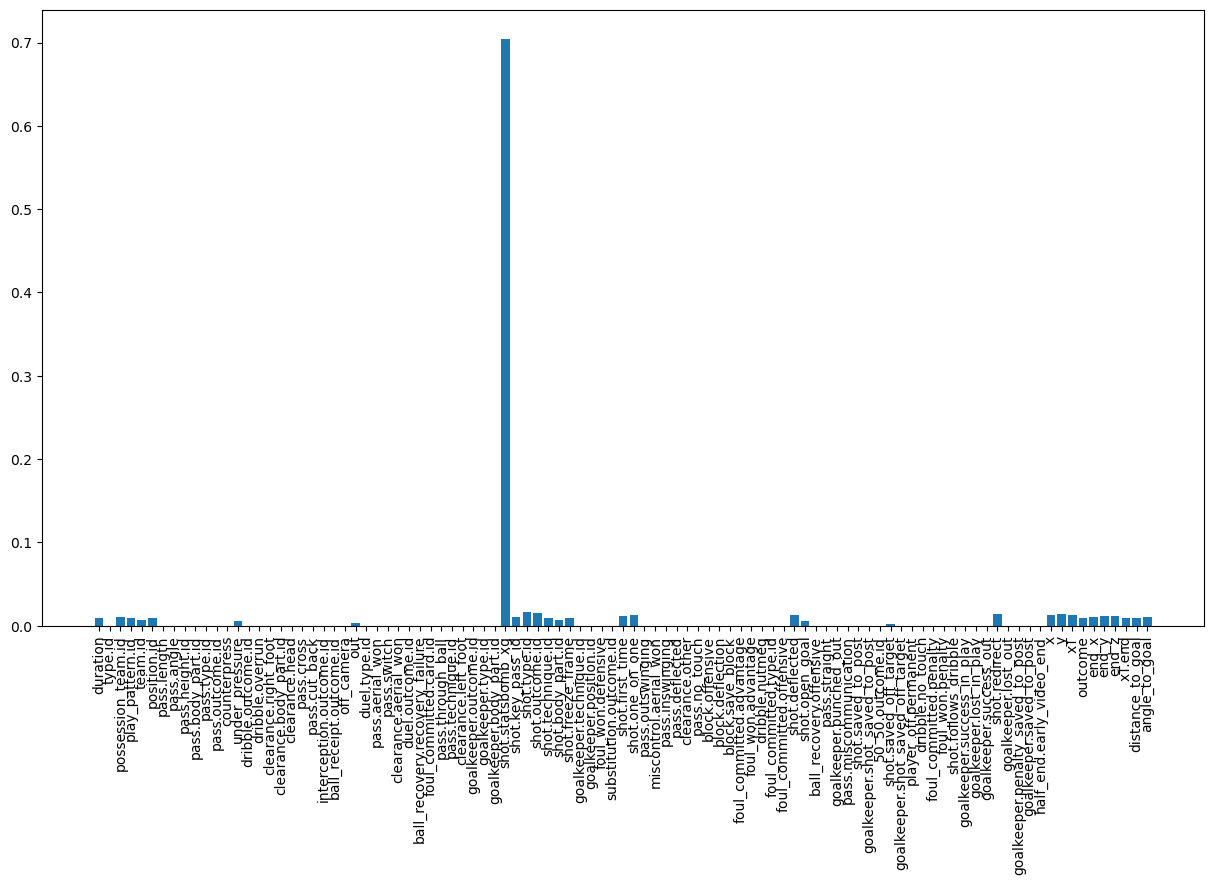

In [985]:

# Predict the PSV
y_pred = xgb.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.show()


## Cross Validation

In [570]:
y_cv = cross_val_predict(xgb, X_train, y_train, cv=5)

In [593]:
obv1 = xgb.predict(X)

In [597]:
r2_score(y, obv1)

0.11270937542555959

In [600]:
X["OBV"] = obv1
X["PSV"] = y

In [601]:
X

,duration,type.id,possession_team.id,play_pattern.id,team.id,position.id,pass.length,pass.angle,pass.height.id,pass.body_part.id,pass.type.id,pass.outcome.id,counterpress,under_pressure,dribble.outcome.id,dribble.overrun,clearance.right_foot,clearance.body_part.id,clearance.head,pass.cross,pass.cut_back,interception.outcome.id,ball_receipt.outcome.id,off_camera,out,duel.type.id,pass.aerial_won,pass.switch,clearance.aerial_won,duel.outcome.id,ball_recovery.recovery_failure,foul_committed.card.id,pass.through_ball,pass.technique.id,clearance.left_foot,goalkeeper.outcome.id,goalkeeper.type.id,goalkeeper.body_part.id,shot.statsbomb_xg,shot.key_pass_id,shot.type.id,shot.outcome.id,shot.technique.id,shot.body_part.id,shot.freeze_frame,goalkeeper.technique.id,goalkeeper.position.id,foul_won.defensive,substitution.outcome.id,shot.first_time,shot.one_on_one,pass.outswinging,miscontrol.aerial_won,pass.inswinging,pass.deflected,clearance.other,pass.no_touch,block.offensive,block.deflection,block.save_block,foul_committed.advantage,foul_won.advantage,dribble.nutmeg,foul_committed.type.id,foul_committed.offensive,shot.deflected,shot.open_goal,ball_recovery.offensive,pass.straight,goalkeeper.punched_out,pass.miscommunication,shot.saved_to_post,goalkeeper.shot_saved_to_post,50_50.outcome.id,shot.saved_off_target,goalkeeper.shot_saved_off_target,player_off.permanent,dribble.no_touch,foul_committed.penalty,foul_won.penalty,shot.follows_dribble,goalkeeper.success_in_play,goalkeeper.lost_in_play,goalkeeper.success_out,shot.redirect,goalkeeper.lost_out,goalkeeper.penalty_saved_to_post,goalkeeper.saved_to_post,half_end.early_video_end,x,y,xT,outcome,end_x,end_y,end_z,xT.end,pred,OBV,PSV
4,1.643562,30,7289,9,7289,22.0,32.635258,-2.632709,1.0,40.0,65.0,8.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60.0,40.0,0.009,1,31.5,24.1,0.0,0.004,0.003586,0.003586,0.0
6,1.672124,43,7289,9,7289,5.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.5,24.1,0.004,0,31.9,21.1,0.0,0.004,0.002262,0.002262,0.0
7,1.427084,30,7289,9,7289,5.0,35.322090,0.187957,3.0,38.0,0.0,9.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.9,21.1,0.004,2,66.6,27.7,0.0,0.010,0.002341,0.002341,0.0
8,2.033153,30,7283,1,7283,11.0,24.834050,-3.089221,3.0,37.0,66.0,8.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.5,52.4,0.007,1,28.7,51.1,0.0,0.004,0.010802,0.010802,0.0
10,0.812119,30,7283,1,7283,3.0,12.865847,-0.101215,2.0,37.0,0.0,8.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.7,51.1,0.004,1,41.5,49.8,0.0,0.005,0.011303,0.011303,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359995,0.000000,9,773,1,907,5.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,1,0.0,0,0,37.0,1,0,0,0.0,0.0,0,0,0.0,0,0,1,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.0,37.8,0.005,0,31.